# Statistical Modelling

- I will use a hierarchical bayesian linear model like Twieki uses here: https://github.com/github/covid19-dashboard/blob/master/_notebooks/2020-03-16-covid19_growth_bayes.ipynb 

In [1]:
import theano

In [2]:
theano.config.device

'cpu'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pymc3 as pm
import arviz as az

In [4]:
sns.set_style('whitegrid')

In [5]:
## load the data
df_cases = pd.read_pickle('./corona_scotland_regions_ts.pk')
df_total = pd.read_pickle('./corona_scotland_total_stats.pk')

In [6]:
max_num_days = len(df_cases)
max_num_days

36

In [7]:
## remove cases where there are hardly any cases
drop_cols = df_cases.columns[df_cases.quantile(0.5) == 0.0]
print(drop_cols)

df_cases = df_cases.drop(columns=drop_cols)

Index(['Eileanan Siar (Western Isles)', 'Orkney'], dtype='object', name='Health Board')


In [8]:
regions = df_cases.columns.values[:-1]
n_regions = len(regions)

In [9]:
np.argwhere(df_cases[regions[0]].gt(10).values).ravel()[0]

13

In [10]:
## find starting days
min_cases = 10
starting_days = {r: np.argwhere(df_cases[r].ge(min_cases).values).ravel()[0] for r in regions}
starting_days

{'Ayrshire and Arran': 13,
 'Borders': 15,
 'Dumfries and Galloway': 14,
 'Fife': 14,
 'Forth Valley': 9,
 'Grampian': 7,
 'Greater Glasgow and Clyde': 6,
 'Highland': 17,
 'Lanarkshire': 8,
 'Lothian': 6,
 'Shetland': 8,
 'Tayside': 8}

### Whole of Scotland

(0.0, 20000.0)

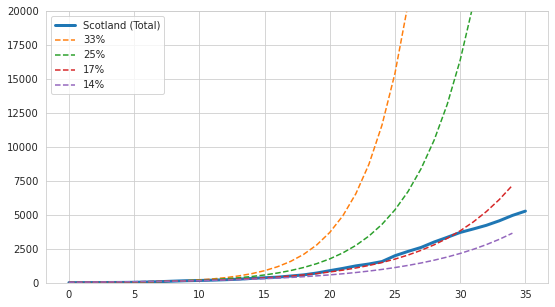

In [11]:
i = 8
c = df_cases['Scotland (Total)'].iloc[i]
df_cases['Scotland (Total)'].reset_index(drop=True)[:].plot(figsize=(9, 5), linewidth=3)
plt.plot(c*(1 + 0.33) ** (np.arange(0, 35, 1)-i), linestyle='--', label='33%')
plt.plot(c*(1 + 0.25) ** (np.arange(0, 35, 1)-i), linestyle='--', label='25%')
plt.plot(c*(1 + 0.17) ** (np.arange(0, 35, 1)-i), linestyle='--', label='17%')
plt.plot(c*(1 + 0.14) ** (np.arange(0, 35, 1)-i), linestyle='--', label='14%')
plt.legend()
plt.ylim(0, 20000)

In [12]:
with pm.Model() as model_scotland:
    
    ### Intercepts ###
    b = pm.Normal('b', 10, 5)
    
    
    ### Slopes ###
    a = pm.Normal('a', 1.18, 0.5)
    
    ### Error ###
    sigma = pm.HalfCauchy('sigma', 50.)
    
    ### Likelihood for Each Region ###
    cases = df_cases['Scotland (Total)'].values[10:]
        
    # From Twieki:
    # By using pm.Data we can change these values after sampling.
    # This allows us to extend x into the future so we can get
    # forecasts by sampling from the posterior predictive
    x = pm.Data('x_data',
                np.arange(10, max_num_days, 1))
    confirmed = pm.Data('y_data',
                        cases)

    # Likelihood
    pm.NegativeBinomial(
        'Scotland (Total)',
        (b * a ** (x-8)), # Exponential regression
        sigma,
        observed=confirmed)

/home/james/local/anaconda3/envs/py36/lib/python3.6/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "


In [13]:
with model_scotland:
    # Sample posterior
    trace_scotland = pm.sample(tune=1000, draws=2000, 
                               chains=2, cores=4, target_accept=0.9,
                               )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, a, b]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:10<00:00, 586.02draws/s]


In [14]:
with model_scotland:
    # Update data so that we get predictions into the future
    x_data = np.arange(0, 40)
    y_data = np.array([np.nan] * len(x_data))
    pm.set_data({'x_data': x_data})
    pm.set_data({'y_data': y_data})
        
    # sample posterior predictive
    post_pred = pm.sample_posterior_predictive(trace_scotland, samples=200)

/home/james/local/anaconda3/envs/py36/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:02<00:00, 72.17it/s]


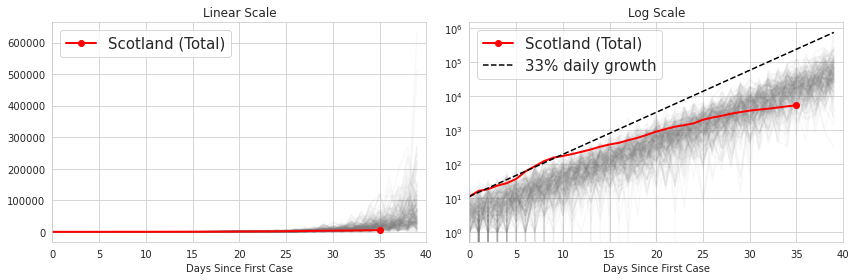

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4.0))
r = 'Scotland (Total)'
y = df_cases[r].iloc[:].values

ax = axes[0]
for sim in post_pred[r]:
    ax.plot(sim, color='gray', alpha=0.05)
ax.plot(y, marker='o', markevery=[len(y)-1],
        color='red', linewidth=2, label=r)
#ax.plot(y[0] * 1.33 ** np.arange(0, 40), label='33% daily growth', color='black', linestyle='--')
ax.set_xlim(0, 40)
ax.set_xlabel('Days Since First Case')
ax.set_title('Linear Scale')
ax.legend(fontsize=15)

ax = axes[1]
for sim in post_pred[r]:
    ax.semilogy(sim, color='gray', alpha=0.05)
ax.semilogy(y, marker='o', markevery=[len(y)-1],
        color='red', linewidth=2, label=r)
ax.semilogy(y[0] * 1.33 ** np.arange(0, 40), label='33% daily growth', color='black', linestyle='--')
ax.set_xlim(0, 40)
ax.set_xlabel('Days Since First Case')
ax.set_title('Log Scale')
ax.legend(fontsize=15)

plt.tight_layout()
plt.show()

In [16]:
pm.stats.summary(trace_scotland)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
b,28.543,4.318,20.507,36.426,0.109,0.077,1560.0,1560.0,1553.0,1685.0,1.0
a,1.281,0.021,1.244,1.321,0.001,0.000,1574.0,1566.0,1677.0,1695.0,1.0
sigma,1.727,0.566,0.763,2.770,0.014,0.010,1593.0,1593.0,1482.0,1840.0,1.0


### Create the Model

In [17]:
with pm.Model() as model:
    
    ### Intercepts ###
    # Group mean
    intr_grp = pm.Normal('intr_grp', 4.3, 2.0)
    # Group variance
    intr_grp_sigma = pm.HalfCauchy('intr_grp_sigma', 2.0)
    
    # Individual intercepts
    intr_ind = pm.Normal('intr_ind',
                          mu=intr_grp,
                          sigma=intr_grp_sigma,
                          shape=n_regions)
    
    
    ### Slopes ###
    # Group mean
    slope_grp = pm.Normal('slope_grp', 1.14, 0.5)
    # Group variance
    slope_grp_sigma = pm.HalfCauchy('slope_grp_sigma', 0.5)
    
    # Individual slopes
    slope_ind = pm.Normal('slope_ind',
                          mu=slope_grp,
                          sigma=slope_grp_sigma,
                          shape=n_regions)
    
    ### Individual Error ###
    sigma = pm.HalfCauchy('sigma', 50., shape=n_regions)
    
    ### Likelihood for Each Region ###
    for i, region in enumerate(regions):
        starting_day = starting_days[region]
        cases_region = df_cases[region].values[starting_day:]
        
        # From Twieki:
        # By using pm.Data we can change these values after sampling.
        # This allows us to extend x into the future so we can get
        # forecasts by sampling from the posterior predictive
        x = pm.Data(region + 'x_data',
                    np.arange(starting_day, max_num_days, 1))
        confirmed = pm.Data(region + 'y_data',
                            cases_region)
        
        # Likelihood
        pm.NegativeBinomial(
            region,
            (intr_ind[i] * slope_ind[i] ** x), # Exponential regression
            sigma[i],
            observed=confirmed)

In [34]:
## non-centered version
with pm.Model() as model_nc:
    
    ### Intercepts ###
    # Group mean
    intr_grp = pm.Normal('intr_grp', 4.3, 2.0)
    # Group variance
    intr_grp_sigma = pm.HalfCauchy('intr_grp_sigma', 2.0)
    
    # Individual intercepts
    #intr_ind = pm.Normal('intr_ind',
    #                      mu=intr_grp,
    #                      sigma=intr_grp_sigma,
    #                      shape=n_regions)
    intr_ind_offset = pm.Normal('intr_ind_offset', 
                                mu=0, 
                                sd=1,
                                shape=n_regions)
   
    intr_ind = pm.Deterministic('intr_ind',
                                intr_grp + intr_ind_offset * intr_grp_sigma)
    
    ### Slopes ###
    # Group mean
    slope_grp = pm.Normal('slope_grp', 1.15, 0.1)
    
    # Group variance
    slope_grp_sigma = pm.HalfCauchy('slope_grp_sigma', 0.1)
    
    # Individual slopes
    #slope_ind = pm.Normal('slope_ind',
    #                      mu=slope_grp,
    #                      sigma=slope_grp_sigma,
    #                      shape=n_regions)
    slope_ind_offset = pm.Normal('slope_ind_offset',
                                 mu=0, 
                                 sd=1,
                                 shape=n_regions)
    
    slope_ind = pm.Deterministic('slope_ind',
                                 slope_grp + slope_ind_offset * slope_grp_sigma)
    
    ### Individual Error ###
    sigma = pm.HalfCauchy('sigma', 50., shape=n_regions)
    
    ### Likelihood for Each Region ###
    for i, region in enumerate(regions):
        cases_region = df_cases[region].values[starting_days[region]:]
        
        # From Twieki:
        # By using pm.Data we can change these values after sampling.
        # This allows us to extend x into the future so we can get
        # forecasts by sampling from the posterior predictive
        x = pm.Data(region + 'x_data',
                    np.arange(0, max_num_days-starting_days[region], 1))
        confirmed = pm.Data(region + 'y_data',
                            cases_region)
        
        # Likelihood
        pm.NegativeBinomial(
            region,
            (intr_ind[i] * slope_ind[i] ** x), # Exponential regression
            sigma[i],
            observed=confirmed)

In [18]:
with model:
    # Sample posterior
    trace = pm.sample(tune=1000, draws=2000, 
                      chains=2, cores=4, target_accept=0.9,
                     )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, slope_ind, slope_grp_sigma, slope_grp, intr_ind, intr_grp_sigma, intr_grp]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [05:26<00:00, 18.38draws/s]


In [19]:
import pickle

In [20]:
pickle.dump(trace, open('trace_1004.pk', 'wb'))
#pickle.dump(model, open('pymc_model_0904.pk', 'wb'))

In [21]:
with model:
    # Update data so that we get predictions into the future
    for i, r in enumerate(regions):
        #cases_region = df_cases[r].values[starting_days[r]:]
        x_data = np.arange(0, 40)
        y_data = np.array([np.nan] * len(x_data))
        pm.set_data({r + 'x_data': x_data})
        pm.set_data({r + 'y_data': y_data})
        
    # sample posterior predictive
    post_pred = pm.sample_posterior_predictive(trace, samples=200)

/home/james/local/anaconda3/envs/py36/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:36<00:00,  5.44it/s]


## Predicted Cases By Region

In [22]:
region_loc = {r: i for i,r in enumerate(regions)}

In [23]:
region_loc

{'Ayrshire and Arran': 0,
 'Borders': 1,
 'Dumfries and Galloway': 2,
 'Fife': 3,
 'Forth Valley': 4,
 'Grampian': 5,
 'Greater Glasgow and Clyde': 6,
 'Highland': 7,
 'Lanarkshire': 8,
 'Lothian': 9,
 'Shetland': 10,
 'Tayside': 11}

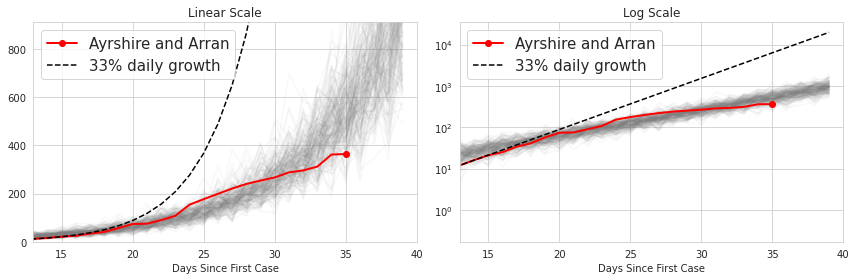

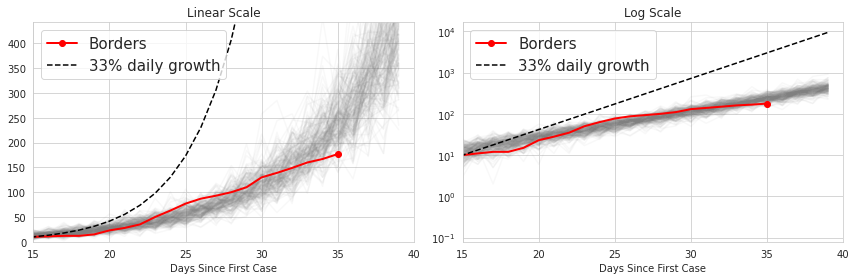

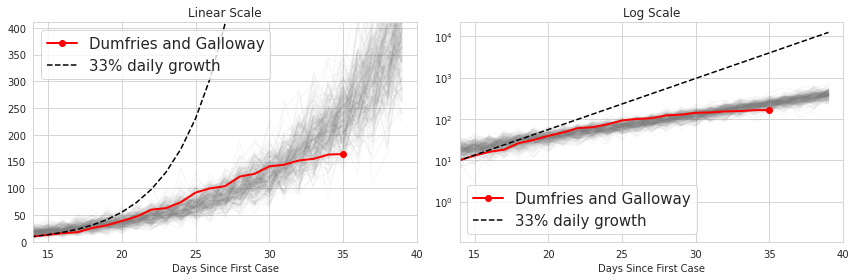

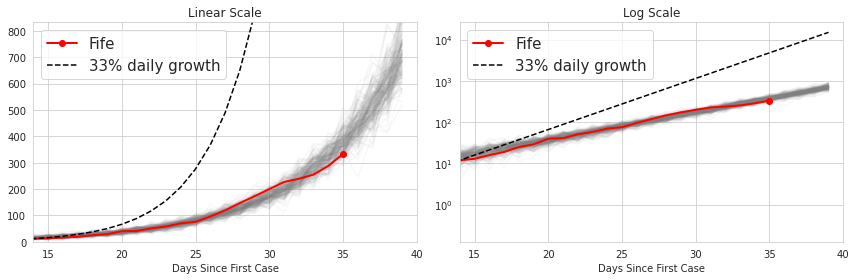

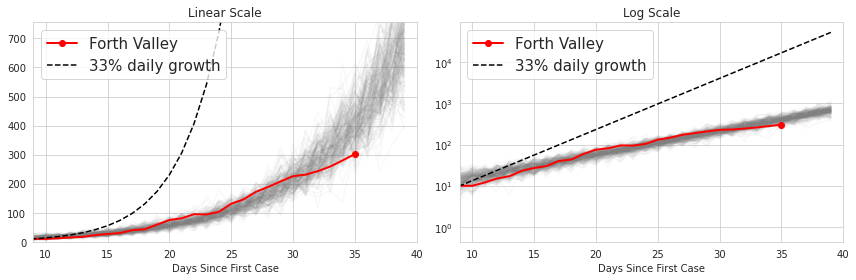

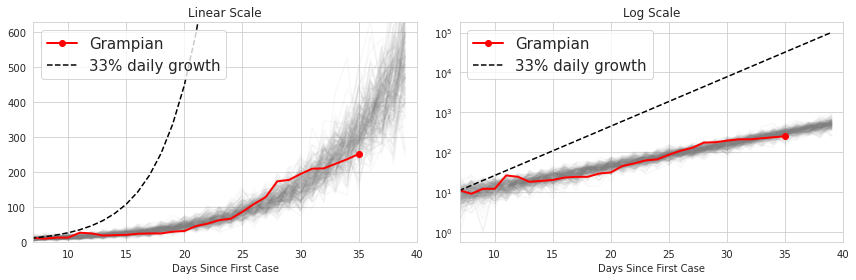

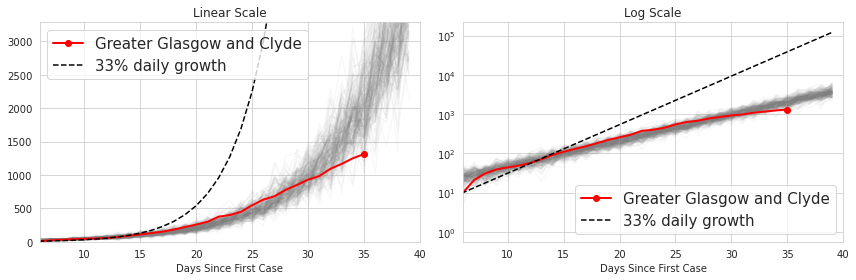

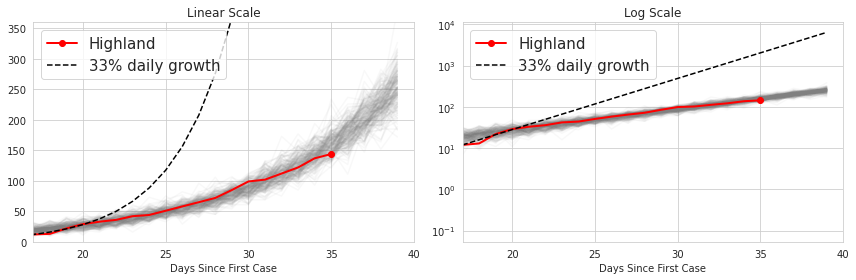

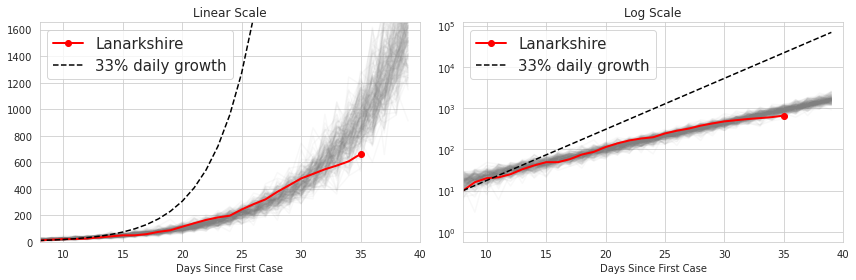

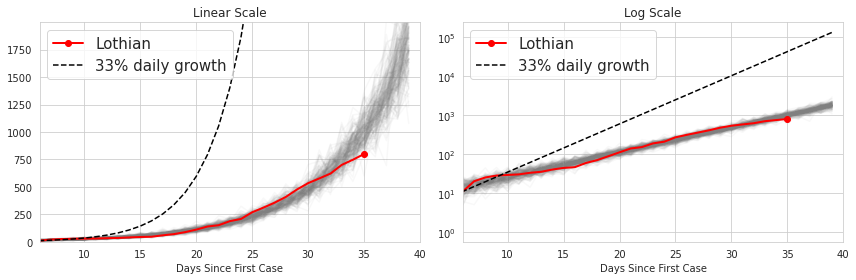

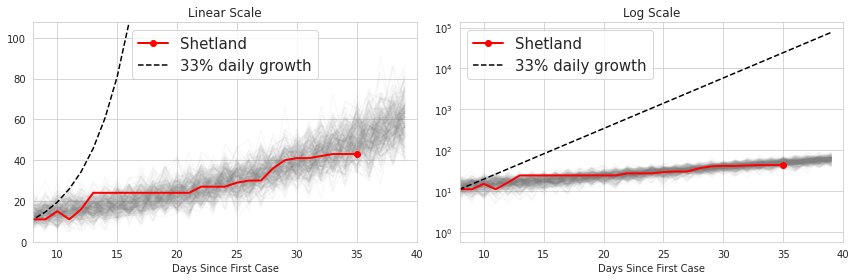

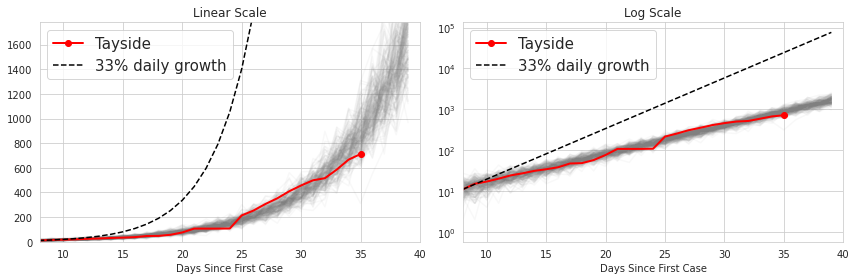

In [24]:
for r in regions:
    y = df_cases[r].iloc[:].values
    start = starting_days[r]

    fig, axes = plt.subplots(1, 2, figsize=(12, 4.0))

    ax = axes[0]
    for sim in post_pred[r]:
        ax.plot(sim, color='gray', alpha=0.05)
    ax.plot(y, marker='o', markevery=[len(y)-1],
            color='red', linewidth=2, label=r)
    ax.plot(y[start] * 1.33 ** (np.arange(0, 40)-start), label='33% daily growth', color='black', linestyle='--')
    ax.set_xlim(start, 40)
    ax.set_ylim(0, 2.5*max(y))
    ax.set_xlabel('Days Since First Case')
    ax.set_title('Linear Scale')
    ax.legend(fontsize=15)

    ax = axes[1]
    for sim in post_pred[r]:
        ax.semilogy(sim, color='gray', alpha=0.05)
    ax.semilogy(y, marker='o', markevery=[len(y)-1],
            color='red', linewidth=2, label=r)
    ax.semilogy(y[start] * 1.33 ** (np.arange(0, 40)-start), label='33% daily growth', color='black', linestyle='--')
    ax.set_xlim(start, 40)
    ax.set_xlabel('Days Since First Case')
    ax.set_title('Log Scale')
    ax.legend(fontsize=15)
    
    plt.tight_layout()
    plt.show()
    

## Posterior Growth Rates Per Region

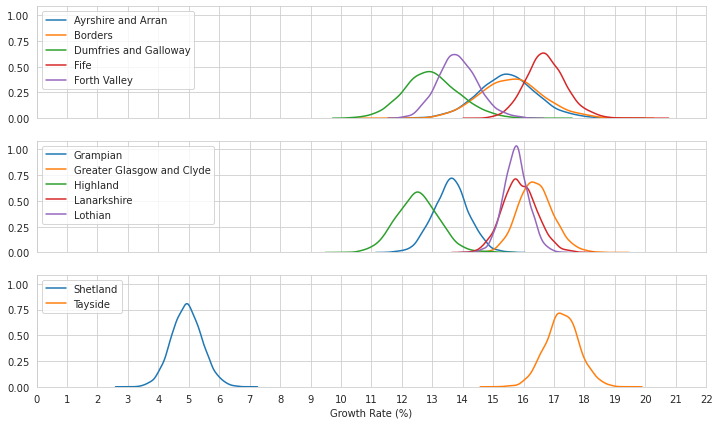

In [25]:
fig, axes = plt.subplots(3, 1, figsize=(12, 7), sharey=True, sharex=True)

for i in range(3):
    ax = axes[i]
    ax.grid()
    for r in regions[i*5: (i+1)*5]:
        sns.distplot((trace['slope_ind'][:, region_loc[r]] * 100 - 100), label=r, hist=False, ax=ax)
        ax.legend(loc=2)
        ax.grid()
    
ax.set_xlabel('Growth Rate (%)') 
ax.set_xticks(np.arange(0, 30))
ax.set_xlim(0, 22)
ax.grid()
plt.show()

Confidence intervals of growth rates for each region.

(Orkney and Western Isles ommitted due to lack of data)

In [26]:
for r in regions:
    print(f"{r} : \t{np.mean(trace['slope_ind'][:, region_loc[r]]):.6}  {pm.stats.hpd(trace['slope_ind'][:, region_loc[r]])}")

Ayrshire and Arran : 	1.15472  [1.13705634 1.17400254]
Borders : 	1.15612  [1.1371184  1.17644067]
Dumfries and Galloway : 	1.12981  [1.11365047 1.14801282]
Fife : 	1.16729  [1.15522879 1.18029127]
Forth Valley : 	1.13844  [1.12591719 1.1505991 ]
Grampian : 	1.13615  [1.12569864 1.14735272]
Greater Glasgow and Clyde : 	1.164  [1.15268342 1.17442806]
Highland : 	1.12522  [1.11124811 1.13754149]
Lanarkshire : 	1.15878  [1.14854843 1.16966695]
Lothian : 	1.15758  [1.14972454 1.16529085]
Shetland : 	1.04939  [1.04021661 1.05923237]
Tayside : 	1.17267  [1.16194038 1.1828911 ]


In [27]:
pm.stats.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
intr_grp,4.556,0.809,3.130,6.151,0.012,0.009,4542.0,4411.0,4520.0,2730.0,1.0
intr_ind[0],3.606,0.789,2.271,5.167,0.013,0.010,3868.0,3245.0,4363.0,2457.0,1.0
intr_ind[1],1.546,0.384,0.873,2.265,0.006,0.004,4202.0,3727.0,4492.0,2749.0,1.0
intr_ind[2],3.383,0.709,2.121,4.713,0.012,0.008,3768.0,3521.0,3876.0,3130.0,1.0
intr_ind[3],1.707,0.269,1.174,2.188,0.004,0.003,4396.0,4096.0,4535.0,2437.0,1.0
intr_ind[4],4.399,0.639,3.194,5.617,0.009,0.007,4559.0,4179.0,4606.0,2571.0,1.0
intr_ind[5],3.570,0.472,2.746,4.505,0.007,0.005,5002.0,4680.0,5216.0,2902.0,1.0
intr_ind[6],10.299,1.165,8.091,12.446,0.018,0.013,4271.0,4210.0,4282.0,2739.0,1.0
intr_ind[7],2.613,0.476,1.784,3.528,0.007,0.005,4259.0,3808.0,4539.0,2485.0,1.0
intr_ind[8],5.356,0.643,4.184,6.571,0.009,0.006,5573.0,5383.0,5441.0,2669.0,1.0


## Model Diagnostics

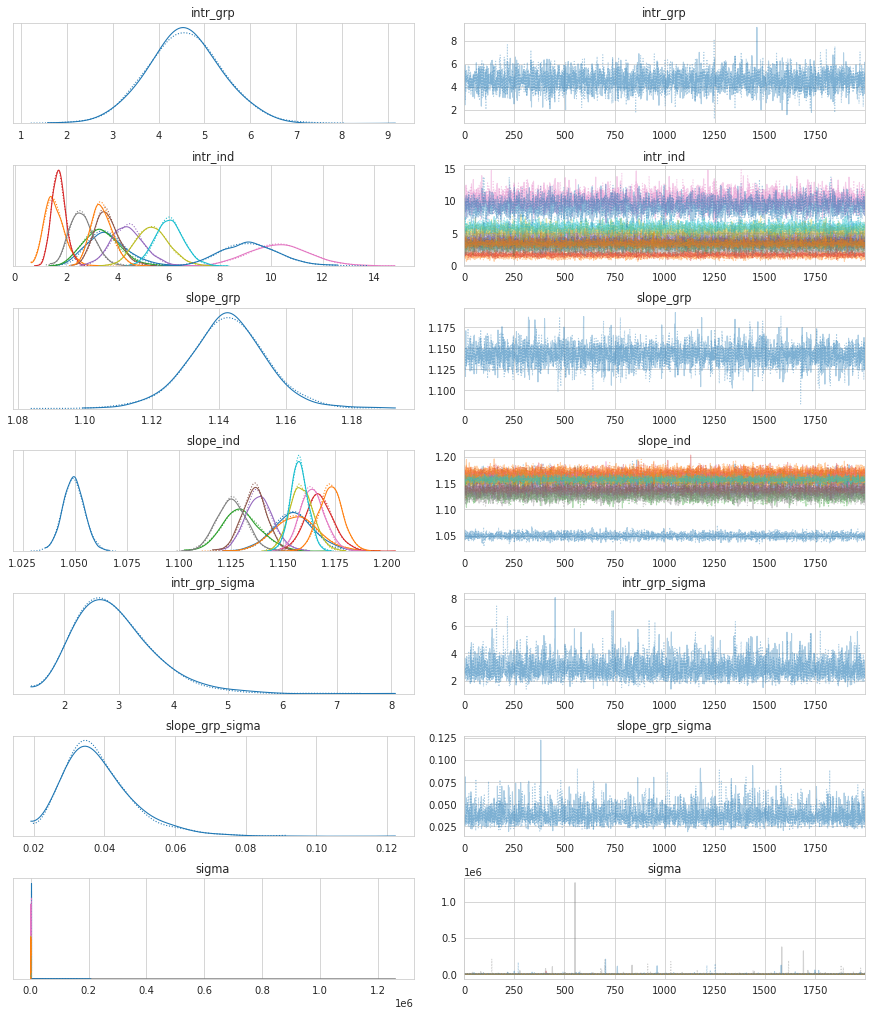

In [28]:
az.plot_trace(trace, compact=True);